# Flood Detection Methods

In [56]:
%matplotlib inline
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import ee; ee.Initialize()

# Configure the pretty printing output
pp = pprint.PrettyPrinter(depth=4)

In [10]:
# Landsat 8 scene from Iowa City, IA (2016)
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')

## Otsu thresholding based on Donchyts et al. (2016), version 1

In [79]:
# Calculate MNDWI
# This should eventually be done with a ML classifier if it's better - What did Dartmouth use? Ask Sam.

mndwi = scene.normalizedDifference(['B3','B7']).rename('mndwi') # L8, renamed 

def thresh(scene):
#     histogram = ndwi.reduceRegion(ee.Reducer.histogram(50).combine('mean', 'mean', True).combine('variance', 'var', True), polygon.buffer(1500), 100, None, None, True)
    histogram = scene.reduceRegion(ee.Reducer.histogram(50).combine('mean', None, True).combine('variance', None, True), None, 100, None, None, True)
    histogram = histogram.get('mndwi_histogram')

    def otsu(histogram):
        counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
        means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
        size = means.length().get([0])
        total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
        sums = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
        mean = sums.divide(total)
        indices = ee.List.sequence(1, size)
  
  ### Compute between sum of squares, where each mean partitions the data.
        def ss(i):
            aCounts = counts.slice(0, 0, i)
            aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0]);
            aMeans = means.slice(0, 0, i);
            aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount)
            bCount = total.subtract(aCount)
            bMean = sums.subtract(aCount.multiply(aMean)).divide(bCount)
            return aCount.multiply(aMean.subtract(mean).pow(2)).add(bCount.multiply(bMean.subtract(mean).pow(2)))
        
        bss = indices.map(ss)
        return means.sort(bss).get([-1])

        #### Return the mean value corresponding to the maximum BSS.
    threshold = otsu(histogram)
#     return scene.addBands(ndwi).set({'threshold': threshold}) # threshold is a property of the ndwi band of this image, don't know how to get this computedobject though so we will just return the number itself for now
#     will eventually probs want to do the image thresholding on server side and not use getInfo, to speed up computation if need be
    return threshold # this is the otsu threshold

#============= With dilated MNDWI

# Canny edge detection
canny = ee.Algorithms.CannyEdgeDetector(mndwi, 0.99, 0)

# Now adding a buffer (morphological dilation) to the edges equal to 1/2 the pixel size (30m / 2  = 15m). 
# Might want to tune this parameter

# Define a kernel (structuring element)
kernel = ee.Kernel.square(radius = 0.5, units = 'pixels')

# Dilate
buffered = canny.focal_max(kernel = kernel, iterations = 2)

# Mask MNDWI
mndwi_mask = mndwi.mask(buffered)

threshold = thresh(mndwi_mask).getInfo()
threshold

# Threshold water from non-water
water = mndwi.gt(threshold)

0.20230463471268975

In [ ]:
# Histogram just from buffer values

histogram = mndwi_mask.select('MNDWI').reduceRegion(reducer = ee.Reducer.histogram(100), bestEffort=True).getInfo()
y = histogram['MNDWI']['histogram'] 
x = [histogram['MNDWI']['bucketWidth'] * v + histogram['MNDWI']['bucketMin'] for v in range(len(y)) ]
plt.plot(x, y)

In [3]:
# #============= With entire MNDWI
scene_threshed = thresh(mndwi)
threshold = scene_threshed.getInfo()

url = mndwi.select('mndwi').lt(threshold).getThumbUrl()
# url = scene_threshed.select('mndwi').lt('threshold').getThumbUrl()
IPython.display.Image(url=url, format='png', embed=True)

histogram = mndwi.select('MNDWI').reduceRegion(reducer = ee.Reducer.histogram(100), bestEffort=True).getInfo()
y = histogram['MNDWI']['histogram'] 
x = [histogram['MNDWI']['bucketWidth'] * v + histogram['MNDWI']['bucketMin'] for v in range(len(y)) ]
plt.plot(x, y)

NameError: name 'thresh' is not defined

***
## Otsu thresholding based on Donchyts et al. (2016), version 1

In [4]:
# Copied from the notebook "Donchyts_cannyedge_NDWI_otsu"

%matplotlib inline

import urllib, io, os

from skimage import filters

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import mapping, shape

from IPython.display import Image, display

import ee


In [5]:
ee.Initialize()

In [16]:
water_bands = ['B3', 'B7'] # consider using B6 like Donchyts, compare?
removeShortEdges = False # ?
water_sigma = 1 # ?
water_threshold = 0.4 # ?
geometry = image.geometry()

0.18016156601562494


(-1, 1)

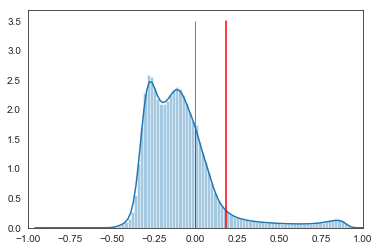

In [24]:
ndwi = image.normalizedDifference(water_bands)   
edge = ee.Algorithms.CannyEdgeDetector(ndwi, water_threshold, water_sigma)

# remove short edges
if removeShortEdges:
    connected = edge.mask(edge).lt(0.8).connectedPixelCount(35, True)
    edgeLong = connected.gte(35)
    edge = edgeLong
    
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = ndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30, maxPixels=1e13).getInfo()

values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 30, maxPixels=1e13).getInfo()

th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [21]:
# detect water
water = ndwi.gt(th)
water_edge = ee.Algorithms.CannyEdgeDetector(water, 0.5, 0)

In [23]:
im = ee.ImageCollection.fromImages([
        image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
        # image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
        water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']}),
        water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
        
    ]).mosaic()


url = im.select().getThumbUrl()
IPython.display.Image(url=url, format='png', embed=True)

TypeError: a bytes-like object is required, not 'NoneType'

TypeError: a bytes-like object is required, not 'NoneType'

<IPython.core.display.Image object>

***
## Notes

 - Canny edge detection and morphological dilation buffer? Used [here](https://www.mdpi.com/2072-4292/8/5/386)
 - Read [this](https://developers.google.com/earth-engine/client_server) on GEE server vs. client sides